<a href="https://colab.research.google.com/github/hmao401/Weather-Forecasting-with-LSTM-GRU-and-ARIMA/blob/main/GHCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Miniproject: Modelling the climate or the weather?

Is past performance an indicator of future weather?

## Global Historial Climatology Network
GHCN (Global Historical Climatology Network)-Daily is an integrated database of daily climate summaries from land surface stations across the globe.

THe GHCN has many datasets from weather stations across the globe. A [README describing the data form is available here](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/readme.txt). The [stations.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt) file and [countries.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt) contain information about the stations and countries.


### Machine Learning Tasks:
1. Can you design a machine learning technique that can predict the climate (defined as the weekly or monthly average) a year in advance?  [Later in the term files containing the 2021 data will be made available
2. Can you design a machine learning technique that can predict the weather (temperature, rainfall, snow fall, etc.) any better than assuming that the weather tomorrow will be exactly the same as the weather today

### Potential extensions
1. Can you train a machine learning technique to predict 10 or 20 years into the future?
2. Where will the hotest part of the world be in 20 years time?
3. What else can you study with this dataset? Is the sun in Utah a predictor of the rain in Spain?
4. How close do weather stations need to be to provide reliable forecasts at other stations?

### Caveats
This is real data from weather stations around the world. This means that there are 'holes' in the data. You must be able to handle these 'holes' in some error tolerant fashion.


### Pre-processing

In [ ]:
# Import all necessary packages
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, accuracy_score
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date

In [ ]:
# Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country

    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

# Class that hides some ugly reading routines
class GHNCD:

    # Class constructor
    def __init__(self):
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)

    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip()
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields

                # For clarity use some variable names
                station=fields[0]
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)

                # Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) # Return a copy

    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')

        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")


    def readStationsFile(self,fileName=None,justGSN=True):

        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')

        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')


            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)

    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        # The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList

    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')

    def printStation(self,sid):
        print(self.stationDict[sid])

    def getStation(self,sid):
        return self.stationDict[sid]

    def getStatKeyNames(self):
        # print(self.stationDict.keys())
        return [*self.stationDict.keys()]



In [ ]:
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

Read 219 countries and codes
Read 991 stations with justGSN True


In [ ]:
# Get list of station names
statNames=ghn.getStatKeyNames()

# Arbitrary number from 0 to 990
whichStat=220
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

# Copy a network object to a local file
urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)
print(ghn.getStation(statNames[whichStat]))


CA002400404 is ARCTIC BAY CS, Canada at 73.0, -85.0167, 10.0


5341


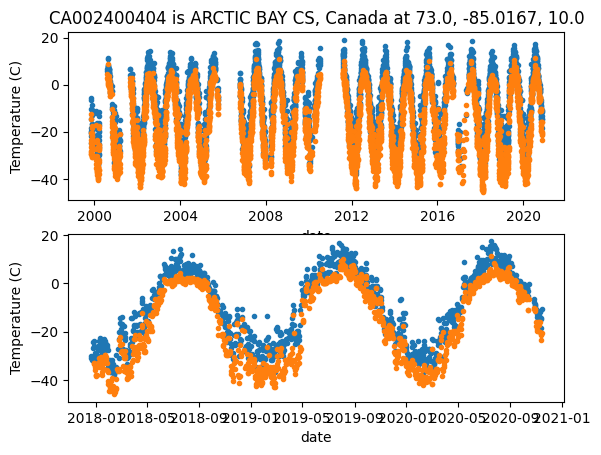

In [ ]:
tmaxArray=ghn.getVar(statDict,'TMAX')
days, tmax = zip(*tmaxArray)
tminArray=ghn.getVar(statDict,'TMIN')
days2, tmin = zip(*tminArray)
print(len(days))
fig, ax = plt.subplots(2,1)
ax[0].plot(days,tmax,'.')
ax[0].plot(days2,tmin,'.')
ax[0].set_xlabel("date")
ax[0].set_ylabel("Temperature (C)")
ax[0].set_title(ghn.getStation(statNames[whichStat]))
ax[1].plot(days[-1000:],tmax[-1000:],'.')
ax[1].plot(days2[-1000:],tmin[-1000:],'.')
ax[1].set_xlabel("date")
ax[1].set_ylabel("Temperature (C)")

prcpArray = ghn.getVar(statDict, 'PRCP')
snowArray = ghn.getVar(statDict, 'SNOW')
days_prcp, prcp = zip(*prcpArray)
days_snow, snow = zip(*snowArray)

## Cleaning the data

### Cleaning/filtering

All missing values (-9999) are firtly replaced with NaN, and data formatting is checked. I alo comverted extracted lists into a Pandas DataFrame for easier manipulation.

In [ ]:
# Check length consistency before merging
print(len(days), len(tmax), len(tmin))

# Create DataFrames for TMAX and TMIN
df_tmax = pd.DataFrame({'date': days, 'TMAX': tmax})
df_tmin = pd.DataFrame({'date': days2, 'TMIN': tmin})

# Convert 'date' column to datetime format
df_tmax["date"] = pd.to_datetime(df_tmax["date"], errors="coerce")
df_tmin["date"] = pd.to_datetime(df_tmin["date"], errors="coerce")

# Merge TMAX and TMIN dataframes on date
df_weather = pd.merge(df_tmax, df_tmin, on="date", how="outer")

5341 5341 5428


In [ ]:
# Replace invalid (-9999) values with NaN
df_weather.replace(-9999, np.nan, inplace=True)

# Convert 'date' column to datetime
df_weather['date'] = pd.to_datetime(df_weather['date'], errors="coerce")

# Ensure 'date' is set as the index for merging
df_weather.set_index('date', inplace=True)

# Create DataFrames for PRCP and SNOW
df_prcp = pd.DataFrame({'date': pd.to_datetime(days_prcp, errors="coerce"), 'PRCP': prcp}).set_index('date')
df_snow = pd.DataFrame({'date': pd.to_datetime(days_snow, errors="coerce"), 'SNOW': snow}).set_index('date')

# Merge precipitation data
df_weather = df_weather.merge(df_prcp, left_index=True, right_index=True, how='outer')

# Merge snowfall data, handling potential column name conflicts
df_weather = df_weather.merge(df_snow, left_index=True, right_index=True, how='outer', suffixes=('', '_snow'))

# If 'SNOW_snow' column was created during merge, combine it with 'SNOW' and drop it
if 'SNOW_snow' in df_weather.columns:
    df_weather['SNOW'] = df_weather['SNOW'].combine_first(df_weather['SNOW_snow'])
    df_weather.drop(columns=['SNOW_snow'], inplace=True)

# Reset index after merging
df_weather.reset_index(inplace=True)

In [ ]:
# Replace invalid (-9999) values with NaN
df_weather.replace(-9999, np.nan, inplace=True)

# Create DataFrames for PRCP and SNOW
df_prcp = pd.DataFrame({'date': pd.to_datetime(days_prcp, errors="coerce"), 'PRCP': prcp})
df_snow = pd.DataFrame({'date': pd.to_datetime(days_snow, errors="coerce"), 'SNOW': snow})

# Merge precipitation data
df_weather = df_weather.merge(df_prcp, on='date', how='outer')

# Merge snowfall data and restore missing values
df_weather = df_weather.merge(df_snow, on='date', how='outer', suffixes=('', '_snow'))
df_weather['SNOW'] = df_weather['SNOW'].combine_first(df_weather['SNOW_snow'])
df_weather.drop(columns=['SNOW_snow'], inplace=True)  # Cleanup redundant column

# Ensure date column is datetime format again after merging
df_weather['date'] = pd.to_datetime(df_weather['date'])


In [ ]:
# Handle missing snowfall data properly
df_weather['SNOW'].fillna(df_snow['SNOW'], inplace=True)  # Use real snowfall data where possible
df_weather['SNOW'].fillna(0, inplace=True)  # Set remaining missing SNOW values to 0

# Apply forward-fill and backward-fill to other missing values
df_weather.fillna(method='ffill', inplace=True)
df_weather.fillna(method='bfill', inplace=True)

# Print sanity checks
print(df_weather.shape)  # Shape of the DataFrame
print(df_weather.head(10))  # First 10 rows
print(df_weather.tail(10))  # Last 10 rows
print(df_weather.isna().sum())  # Count remaining NaN values

(5566, 6)
        date  TMAX  TMIN  PRCP_x  SNOW  PRCP_y
0 1999-11-01 -18.6 -29.3     0.0   0.0     0.0
1 1999-11-02 -18.6 -29.3     0.0   0.0     0.0
2 1999-11-03 -18.6 -29.3     0.0   0.0     0.0
3 1999-11-04 -18.6 -29.3     0.0   0.0     0.0
4 1999-11-05 -18.6 -29.3     0.0   0.0     0.0
5 1999-11-06 -18.6 -29.3     0.0   0.0     0.0
6 1999-11-07 -20.5 -24.6     0.0   0.0     0.0
7 1999-11-08 -20.3 -26.4     0.0   0.0     0.0
8 1999-11-09 -24.8 -28.5     0.0   0.0     0.0
9 1999-11-10 -19.8 -28.0     0.0   0.0     0.0
           date  TMAX  TMIN  PRCP_x  SNOW  PRCP_y
5556 2020-11-05 -14.5 -17.2     0.1   0.0     0.1
5557 2020-11-06 -14.5 -19.5     0.4   0.0     0.4
5558 2020-11-07 -13.5 -17.4     1.7   0.0     1.7
5559 2020-11-08 -13.3 -16.0     0.0   0.0     0.0
5560 2020-11-09 -11.7 -16.0     0.1   0.0     0.1
5561 2020-11-10 -11.3 -20.3     0.2   0.0     0.2
5562 2020-11-11 -18.6 -23.5     0.0   0.0     0.0
5563 2020-11-12 -14.7 -20.9     0.8   0.0     0.8
5564 2020-11-13 -14.5 -

<ipython-input-71-d9f4be9bddd3>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_weather['SNOW'].fillna(df_snow['SNOW'], inplace=True)  # Use real snowfall data where possible
<ipython-input-71-d9f4be9bddd3>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doin

In [ ]:
# Resolve duplicate PRCP columns after merging
if 'PRCP_x' in df_weather.columns and 'PRCP_y' in df_weather.columns:
    df_weather['PRCP'] = df_weather[['PRCP_x', 'PRCP_y']].max(axis=1)  # Take the max value if both exist
    df_weather.drop(columns=['PRCP_x', 'PRCP_y'], inplace=True)  # Remove redundant columns

# Ensure 'PRCP' column is present before applying transformations
if 'PRCP' not in df_weather.columns:
    raise KeyError("PRCP column is missing after merging. Check the data sources.")

# Log-transform precipitation to normalize distribution
df_weather["PRCP"] = np.log1p(df_weather["PRCP"])

# Extract month and day of the week for seasonality awareness
df_weather['Month'] = df_weather['date'].dt.month
df_weather['DayOfWeek'] = df_weather['date'].dt.dayofweek

# Add lag features safely
df_weather['TMAX_lag1'] = df_weather['TMAX'].shift(1)
df_weather['TMIN_lag1'] = df_weather['TMIN'].shift(1)
df_weather['PRCP_lag1'] = df_weather['PRCP'].shift(1) if 'PRCP' in df_weather.columns else np.nan
df_weather['SNOW_lag1'] = df_weather['SNOW'].shift(1) if 'SNOW' in df_weather.columns else np.nan



In [ ]:
# Set date as the index for resampling
df_weather.set_index("date", inplace=True)

# Resample to weekly and monthly averages
df_weekly = df_weather.resample("W").mean()
df_monthly = df_weather.resample("M").mean()

# Fill any remaining missing values
df_monthly.ffill(inplace=True)
df_monthly.bfill(inplace=True)

# Double-check for missing values after resampling
print("Missing values after resampling:")
print(df_monthly.isna().sum())

Missing values after resampling:
TMAX         0
TMIN         0
SNOW         0
PRCP         0
Month        0
DayOfWeek    0
TMAX_lag1    0
TMIN_lag1    0
PRCP_lag1    0
SNOW_lag1    0
dtype: int64


<ipython-input-73-5383510645f6>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_weather.resample("M").mean()


In [ ]:
# Sanity check
print(df_weather.shape)  # (rows, columns)
print(df_weather.head(10))  # Show the first 10 rows
print(df_weather.tail(10))  # Show the last 10 rows
print(df_weather.isna().sum())

(5566, 10)
            TMAX  TMIN  SNOW  PRCP  Month  DayOfWeek  TMAX_lag1  TMIN_lag1  \
date                                                                         
1999-11-01 -18.6 -29.3   0.0   0.0     11          0        NaN        NaN   
1999-11-02 -18.6 -29.3   0.0   0.0     11          1      -18.6      -29.3   
1999-11-03 -18.6 -29.3   0.0   0.0     11          2      -18.6      -29.3   
1999-11-04 -18.6 -29.3   0.0   0.0     11          3      -18.6      -29.3   
1999-11-05 -18.6 -29.3   0.0   0.0     11          4      -18.6      -29.3   
1999-11-06 -18.6 -29.3   0.0   0.0     11          5      -18.6      -29.3   
1999-11-07 -20.5 -24.6   0.0   0.0     11          6      -18.6      -29.3   
1999-11-08 -20.3 -26.4   0.0   0.0     11          0      -20.5      -24.6   
1999-11-09 -24.8 -28.5   0.0   0.0     11          1      -20.3      -26.4   
1999-11-10 -19.8 -28.0   0.0   0.0     11          2      -24.8      -28.5   

            PRCP_lag1  SNOW_lag1  
date             

### Initial preprocessing

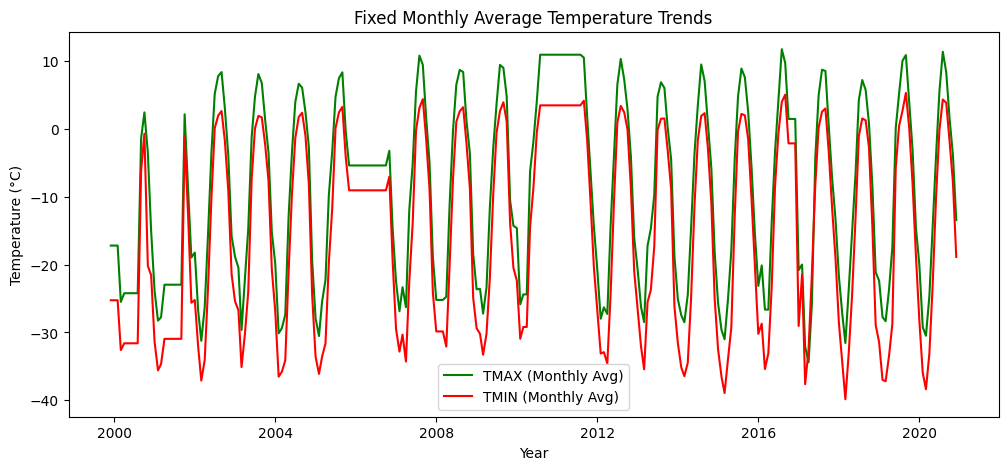

In [ ]:
# Plots the monthly trends of average temperature (tmin and tmax)
plt.figure(figsize=(12, 5))
plt.plot(df_monthly.index, df_monthly["TMAX"], label="TMAX (Monthly Avg)", color="green")
plt.plot(df_monthly.index, df_monthly["TMIN"], label="TMIN (Monthly Avg)", color="red")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Fixed Monthly Average Temperature Trends")
plt.legend()
plt.show()

Polynomial and spline interpolation methods were tried in order to fill missing values, but they either introduced instability, unrealistic oscillations, or failed due to date index constraints. As a result, forward-fill (ffill) and backward-fill (bfill) were chosen as the most reliable approach.


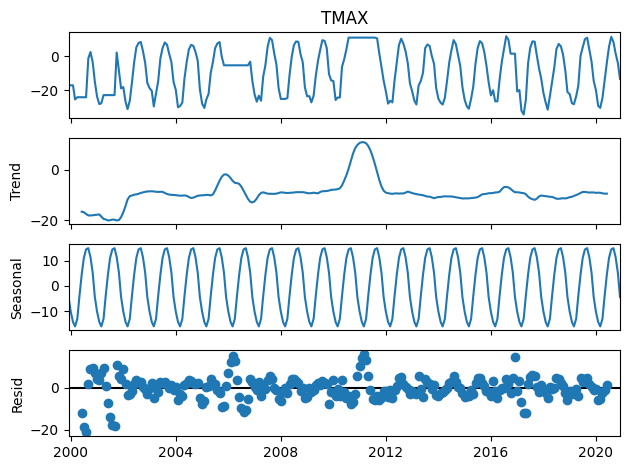


Summary Statistics:
              TMAX         TMIN         SNOW         PRCP        Month  \
count  5566.000000  5566.000000  5566.000000  5566.000000  5566.000000   
mean     -9.656522   -15.924524     0.240568     0.097863     6.659899   
std      14.116641    14.899149     3.078339     0.313664     3.455875   
min     -39.200000   -45.800000     0.000000     0.000000     1.000000   
25%     -22.300000   -29.800000     0.000000     0.000000     4.000000   
50%      -8.800000   -15.800000     0.000000     0.000000     7.000000   
75%       3.200000    -0.500000     0.000000     0.000000    10.000000   
max      19.100000    11.500000    80.000000     3.384390    12.000000   

         DayOfWeek    TMAX_lag1    TMIN_lag1    PRCP_lag1    SNOW_lag1  
count  5566.000000  5565.000000  5565.000000  5565.000000  5565.000000  
mean      3.006109    -9.656334   -15.923720     0.097775     0.240611  
std       1.996123    14.117902    14.900367     0.313624     3.078614  
min       0.000000  

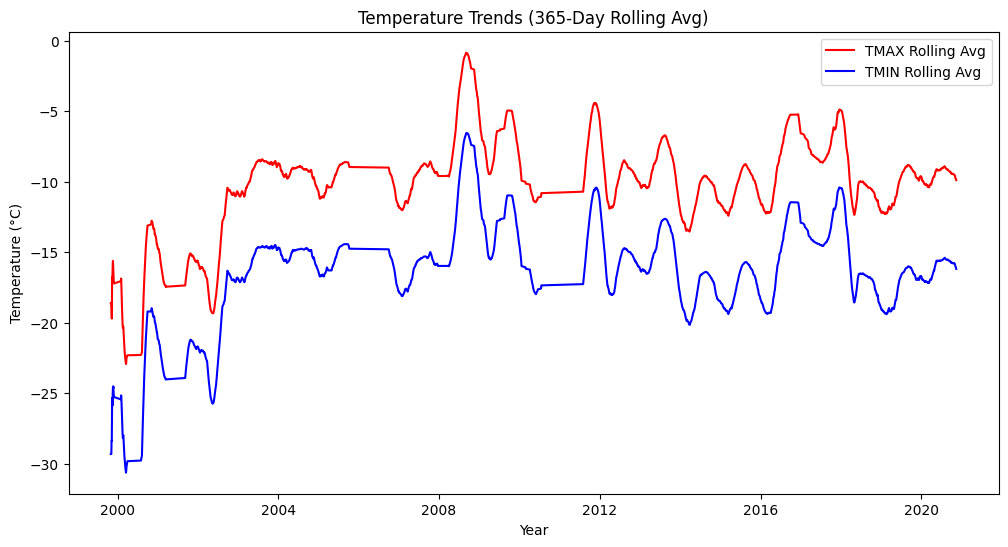

In [ ]:
# Seasonal decomposition
decomposition = seasonal_decompose(df_monthly["TMAX"], model="additive", period=12)
decomposition.plot()
plt.show()

# Summary of statistics
print("\nSummary Statistics:")
print(df_weather.describe())

# Calculates rolling average trends
df_weather['TMAX_rolling'] = df_weather["TMAX"].rolling(window=365, min_periods=1).mean()
df_weather['TMIN_rolling'] = df_weather["TMIN"].rolling(window=365, min_periods=1).mean()

# Plots the rolling averages
plt.figure(figsize=(12, 6))
plt.plot(df_weather.index, df_weather['TMAX_rolling'], label='TMAX Rolling Avg', color='red')
plt.plot(df_weather.index, df_weather['TMIN_rolling'], label='TMIN Rolling Avg', color='blue')
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trends (365-Day Rolling Avg)")
plt.legend()
plt.show()


The summary statistics provide insight into the dataset's temperature distribution:
- `count`: Number of data points available for TMAX and TMIN.
- `mean`: The average temperature over the dataset.
- `std`: Standard deviation, indicating variability in temperature.
- `min` and `max`: The lowest and highest recorded temperatures.
- `25%`, `50% (median)`, `75%`: Quartiles showing the spread of temperature values.

The `TMAX` (Maximum Temperature) and `TMIN` (Minimum Temperature) monthly averages demonstrate seasonal variations, with clear periodic fluctuations over time. The rolling average trend indicates long-term temperature shifts, highlighting periods of warming and cooling.
Seasonal decomposition shows distinct cyclical patterns in TMAX, confirming
the influence of yearly weather cycles.
The data also highlights extreme temperature events, which can be valuable for
identifying climate anomalies or trends in temperature variability over the years.

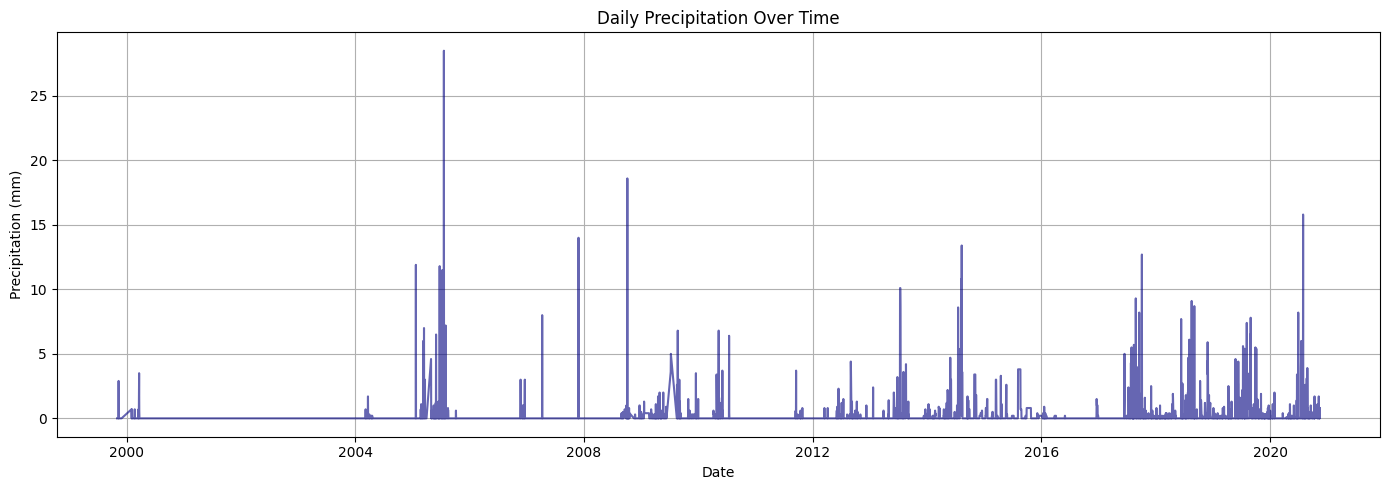

In [ ]:
# Plots all precipitation data
plt.figure(figsize=(14, 5))
plt.plot(df_weather.index, np.expm1(df_weather['PRCP']), color='navy', alpha=0.6)
plt.title("Daily Precipitation Over Time")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()


count     22.000000
mean      60.863636
std      127.881007
min        0.000000
25%        0.000000
50%        0.000000
75%       45.250000
max      426.000000
Name: SNOW, dtype: float64
Year
1999      0.0
2000     40.0
2001    420.0
2002    206.0
2003      0.0
2004     47.0
2005    426.0
2006    120.0
2007     80.0
2008      0.0
2009      0.0
2010      0.0
2011      0.0
2012      0.0
2013      0.0
2014      0.0
2015      0.0
2016      0.0
2017      0.0
2018      0.0
2019      0.0
2020      0.0
Name: SNOW, dtype: float64


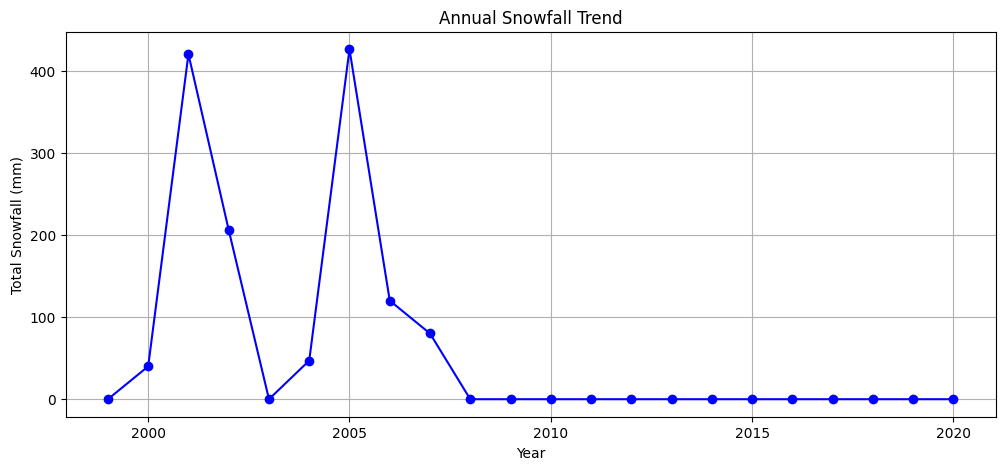

In [ ]:
# Group by year and sum snowfall
df_weather['Year'] = df_weather.index.year
annual_snowfall = df_weather.groupby('Year')['SNOW'].sum()

# Display annual snowfall statistics
print(annual_snowfall.describe())
print(annual_snowfall)


plt.figure(figsize=(12, 5))
plt.plot(annual_snowfall.index, annual_snowfall.values, marker='o', linestyle='-', color='b')
plt.xlabel("Year")
plt.ylabel("Total Snowfall (mm)")
plt.title("Annual Snowfall Trend")
plt.grid(True)
plt.show()


In [ ]:
# Convert to binary snowfall occurrence (1 if snow > 0 on a given day)
df_weather['Snow_Occurred'] = (df_weather['SNOW'] > 0).astype(int)

# Count the number of snow days per year
annual_snow_days = df_weather.groupby('Year')['Snow_Occurred'].sum()

# Display annual snow day statistics
print(annual_snow_days.describe())
print(annual_snow_days)


count    22.000000
mean      3.500000
std       6.337718
min       0.000000
25%       0.000000
50%       0.000000
75%       5.500000
max      20.000000
Name: Snow_Occurred, dtype: float64
Year
1999     0
2000    10
2001    19
2002     9
2003     0
2004    11
2005    20
2006     7
2007     1
2008     0
2009     0
2010     0
2011     0
2012     0
2013     0
2014     0
2015     0
2016     0
2017     0
2018     0
2019     0
2020     0
Name: Snow_Occurred, dtype: int64


No significant snowfall activity before 2008, in fact after 2008 - there is 0 snowfall occurences. This means snowfall is not a useful predictor, beyond 2008 at least. Model will not be able to learn meaningfull patterns so instead I will focus on temperature and precipiation.

### Checking for outliers?

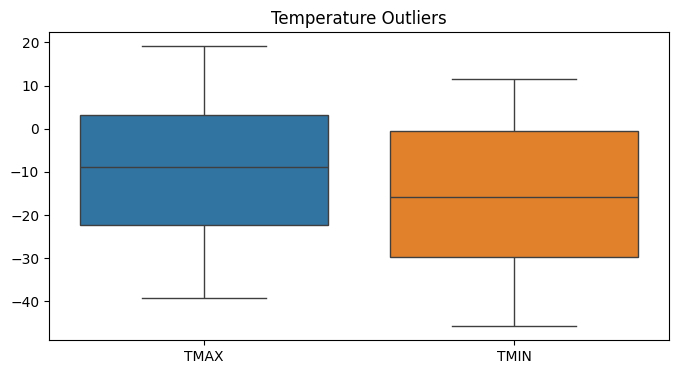

Number of TMAX outliers: 0
Number of TMIN outliers: 0


In [ ]:
# Create a boxplot in attempts to visualise outliers
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_weather[['TMAX', 'TMIN']])
plt.title("Temperature Outliers")
plt.show()

# Calculate the IQR for TMAX and TMIN
Q1 = df_weather[['TMAX', 'TMIN']].quantile(0.25)
Q3 = df_weather[['TMAX', 'TMIN']].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify any possible outliers
outliers_TMAX = (df_weather["TMAX"] < lower_bound["TMAX"]) | (df_weather["TMAX"] > upper_bound["TMAX"])
outliers_TMIN = (df_weather["TMIN"] < lower_bound["TMIN"]) | (df_weather["TMIN"] > upper_bound["TMIN"])

# Output the number of outliers
print("Number of TMAX outliers:", outliers_TMAX.sum())
print("Number of TMIN outliers:", outliers_TMIN.sum())

The whiskers or lines extending beyond the box represent the range within 1.5xIQR of the quartiles, and since there are no points/dots outside this range - there seem to be no outliers. TMAX and TMIN appear to behave normally and have expected seasonal variation without any extreme values, well distributed data.

<ipython-input-81-07d952bd560d>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


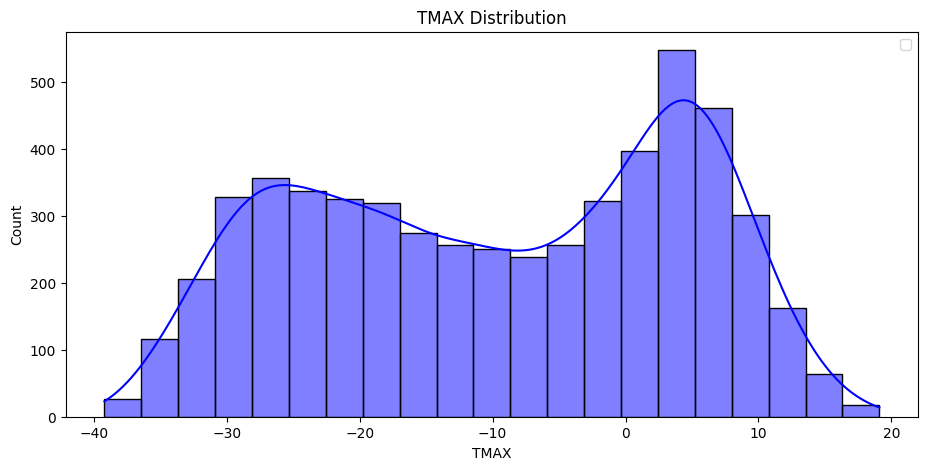

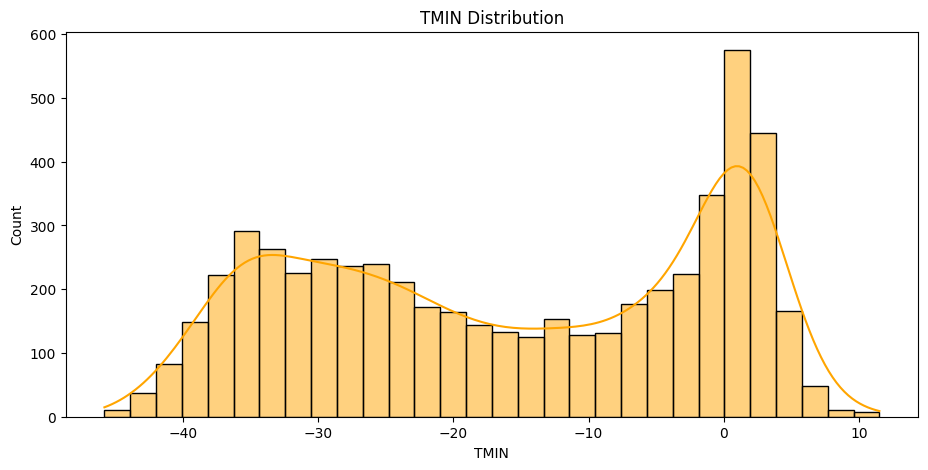

In [ ]:
# Plotting histograms for TMAX and TMIN
plt.figure(figsize=(11, 5))
sns.histplot(df_weather["TMAX"], color="blue", kde=True)
plt.title("TMAX Distribution")
plt.legend()
plt.show()

plt.figure(figsize=(11, 5))
sns.histplot(df_weather["TMIN"], color="orange", bins=30, kde=True)
plt.xlabel("TMIN")
plt.ylabel("Count")
plt.title("TMIN Distribution")
plt.show()


Both distributions are bimodal with TMIN having a lower temperature range than TMAX as expected since it represents the coldest temperature of the day. This suggests nights tend to be much colder - which is a typical diurnal cycle behaviour.

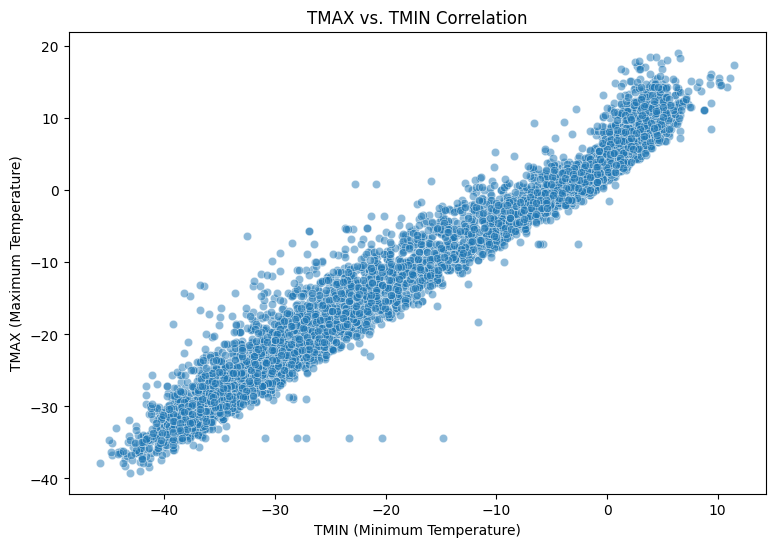

Pearson Correlation Coefficient: 0.98


In [ ]:
# Plots a scatterplot of a comparison of TMAX and TMIN
plt.figure(figsize=(9, 6))
sns.scatterplot(x=df_weather["TMIN"], y=df_weather["TMAX"], alpha=0.5)
plt.xlabel("TMIN (Minimum Temperature)")
plt.ylabel("TMAX (Maximum Temperature)")
plt.title("TMAX vs. TMIN Correlation")
plt.show()

# Calculates and displays the correlation coefficient
correlation = df_weather["TMIN"].corr(df_weather["TMAX"])
print(f"Pearson Correlation Coefficient: {correlation:.2f}")

Strong positive correlation with an almost perfect linear relationship between TMAX and TMIN which means as TMIN increases, TMAX also increases as expected.

TMIN is a strong indicator/predictor of TMAX...

📊 Precipitation Summary Statistics:
count    5566.000000
mean        0.097863
std         0.313664
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.384390
Name: PRCP, dtype: float64

Outlier Summary:
Number of PRCP outliers: 894
Upper Bound: 0.000, Lower Bound: 0.000


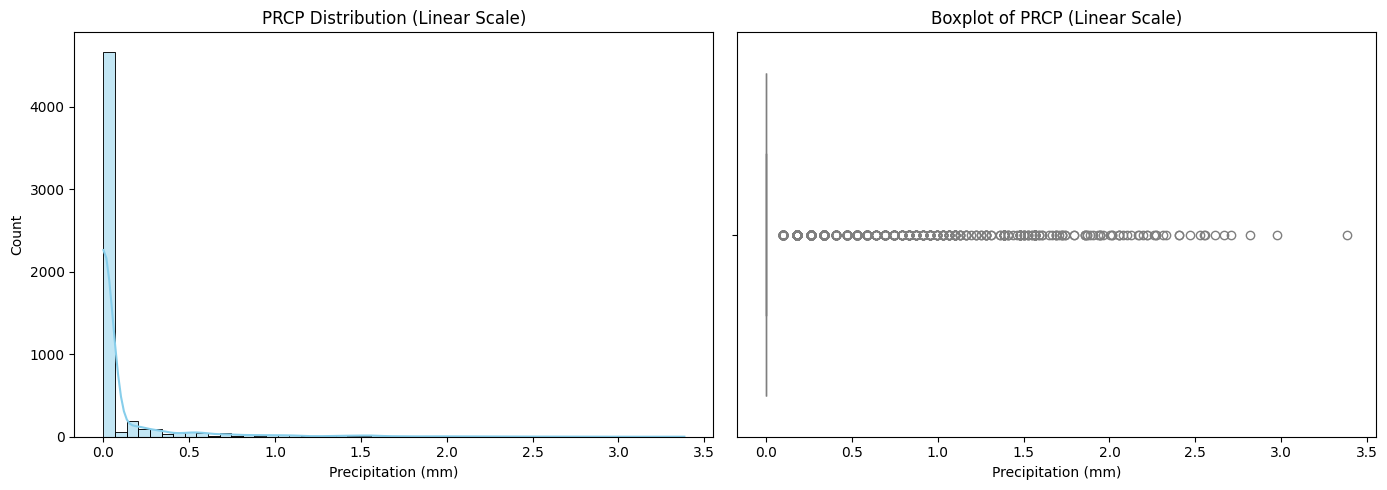

In [ ]:
# Summary statistics
print("📊 Precipitation Summary Statistics:")
print(df_weather['PRCP'].describe())

# Calculate IQR
Q1_prcp = df_weather['PRCP'].quantile(0.25)
Q3_prcp = df_weather['PRCP'].quantile(0.75)
IQR_prcp = Q3_prcp - Q1_prcp

# Define outlier bounds
lower_bound_prcp = Q1_prcp - 1.5 * IQR_prcp
upper_bound_prcp = Q3_prcp + 1.5 * IQR_prcp

# Identify outliers
outliers_prcp = (df_weather['PRCP'] < lower_bound_prcp) | (df_weather['PRCP'] > upper_bound_prcp)
print(f"\nOutlier Summary:")
print(f"Number of PRCP outliers: {outliers_prcp.sum()}")
print(f"Upper Bound: {upper_bound_prcp:.3f}, Lower Bound: {lower_bound_prcp:.3f}")

# Plot distribution and boxplot
plt.figure(figsize=(14, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_weather['PRCP'], bins=50, kde=True, color='skyblue')
plt.title("PRCP Distribution (Linear Scale)")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Count")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_weather['PRCP'], color='lightgray')
plt.title("Boxplot of PRCP (Linear Scale)")
plt.xlabel("Precipitation (mm)")

plt.tight_layout()
plt.show()



The first histogram shows that most precipitation values are close to zero, with a long right tail indicating occasional heavier rainfall. The second boxplot reveals seasonal variation, with summer months showing greater variability and more frequent high-precipitation outliers.

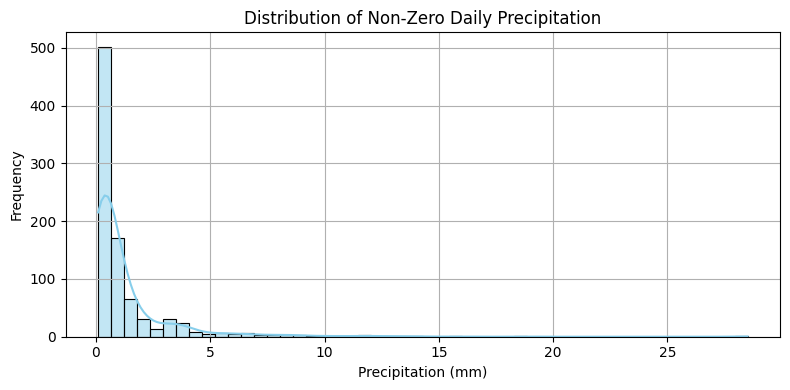

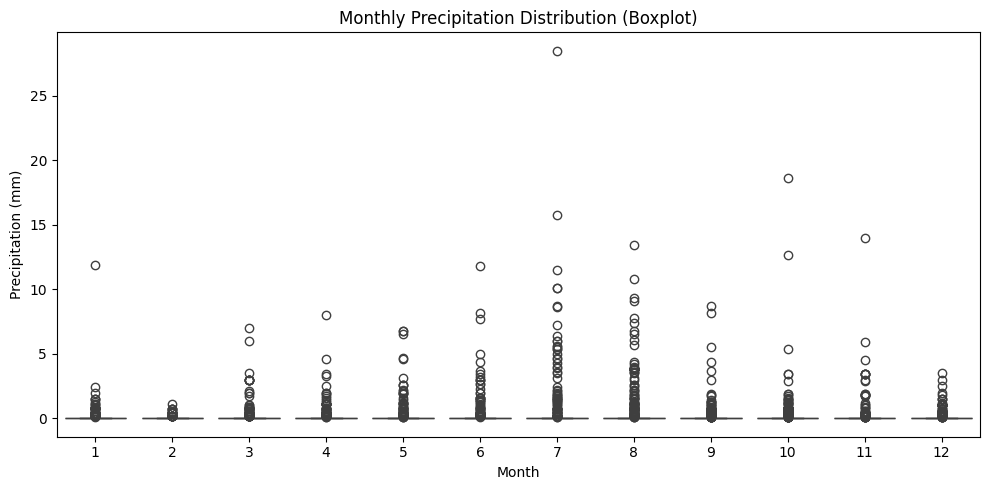

In [ ]:
# Create a new column for actual PRCP values
df_weather['PRCP_actual'] = np.expm1(df_weather['PRCP'])

# Filter data to include only non-zero actual precipitation
non_zero_prcp = df_weather[df_weather['PRCP_actual'] > 0]

# Plot a histogram of non-zero actual precipitation
plt.figure(figsize=(8, 4))
sns.histplot(non_zero_prcp['PRCP_actual'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Non-Zero Daily Precipitation")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract month for analysis
df_weather['Month'] = df_weather.index.month

# Plot a boxplot of monthly precipitation distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='Month', y='PRCP_actual', data=df_weather)
plt.title("Monthly Precipitation Distribution (Boxplot)")
plt.xlabel("Month")
plt.ylabel("Precipitation (mm)")
plt.tight_layout()
plt.show()

This histogram and boxplot (including zeros) confirm that dry days dominate the dataset, leading to a highly skewed distribution. Overall, precipitation is infrequent but occasionally intense, and its distribution is both sparse and seasonal.

## Task 1: Predicting Climate (long-term)

### Using LTSM model

In [ ]:
# --- Assume you have df_monthly with TMAX, TMIN, PRCP, Month_sin, Month_cos ---

# Feature columns
features = ['TMAX', 'TMIN', 'PRCP', 'Month_sin', 'Month_cos']
target = ['TMAX', 'TMIN', 'PRCP']

# 1. Add Month_sin and Month_cos to df_monthly:
df_monthly = df_monthly.reset_index() #Reset index to access the 'date' column
df_monthly['Month'] = df_monthly['date'].dt.month
df_monthly['Month_sin'] = np.sin(2 * np.pi * df_monthly['Month'] / 12)
df_monthly['Month_cos'] = np.cos(2 * np.pi * df_monthly['Month'] / 12)

# 2. Update features list:
features = ['TMAX', 'TMIN', 'PRCP', 'Month_sin', 'Month_cos'] # Include new features

# Normalize features
scaler = MinMaxScaler()
df_scaled = df_monthly.copy()
df_scaled[features] = scaler.fit_transform(df_monthly[features])

# Prepare sequence data (12-month lookback to predict 13th month)
def create_sequences(data, sequence_length=12):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length][:3])  # Only TMAX, TMIN, PRCP
    return np.array(X), np.array(y)

data_array = df_scaled[features].values
X, y = create_sequences(data_array)

# Split based on date
dates = df_monthly['date'].values[12:]
split_idx = np.where(pd.to_datetime(dates) < np.datetime64("2020-01"))[0][-1] + 1

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dates_test = dates[split_idx:]

In [ ]:
# --- Build LSTM model ---
model = Sequential()
model.add(LSTM(64, input_shape=(X_all.shape[1], X_all.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(3))  # TMAX, TMIN, PRCP

model.compile(optimizer='adam', loss='mae')
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# --- Train model (we’ll use validation split from train set) ---
model.fit(X_train, y_train, epochs=50, batch_size=16,
          validation_split=0.1, callbacks=[early_stop], verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.3197 - val_loss: 0.2173
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2031 - val_loss: 0.1996
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1725 - val_loss: 0.1793
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1678 - val_loss: 0.1423
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1346 - val_loss: 0.0959
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1230 - val_loss: 0.0850
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1046 - val_loss: 0.0627
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1009 - val_loss: 0.0594
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0937 - val_loss: 0.0579
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0894 - val_loss: 0.0568
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0876 - val_loss: 0.0549
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

In [ ]:
# --- Predict on 2021 ---
y_pred = model.predict(X_test)

# --- Inverse scale for interpretability ---
pad = np.zeros((len(y_pred), 2))
y_pred_inv = scaler.inverse_transform(np.hstack([y_pred, pad]))[:, :3]
y_test_inv = scaler.inverse_transform(np.hstack([y_test, pad]))[:, :3]

# --- Evaluation ---
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"LSTM Climate MAE (2021): {mae:.2f}")
print(f"LSTM Climate R² Score (2021): {r2:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
LSTM Climate MAE (2021): 1.07
LSTM Climate R² Score (2021): 0.72


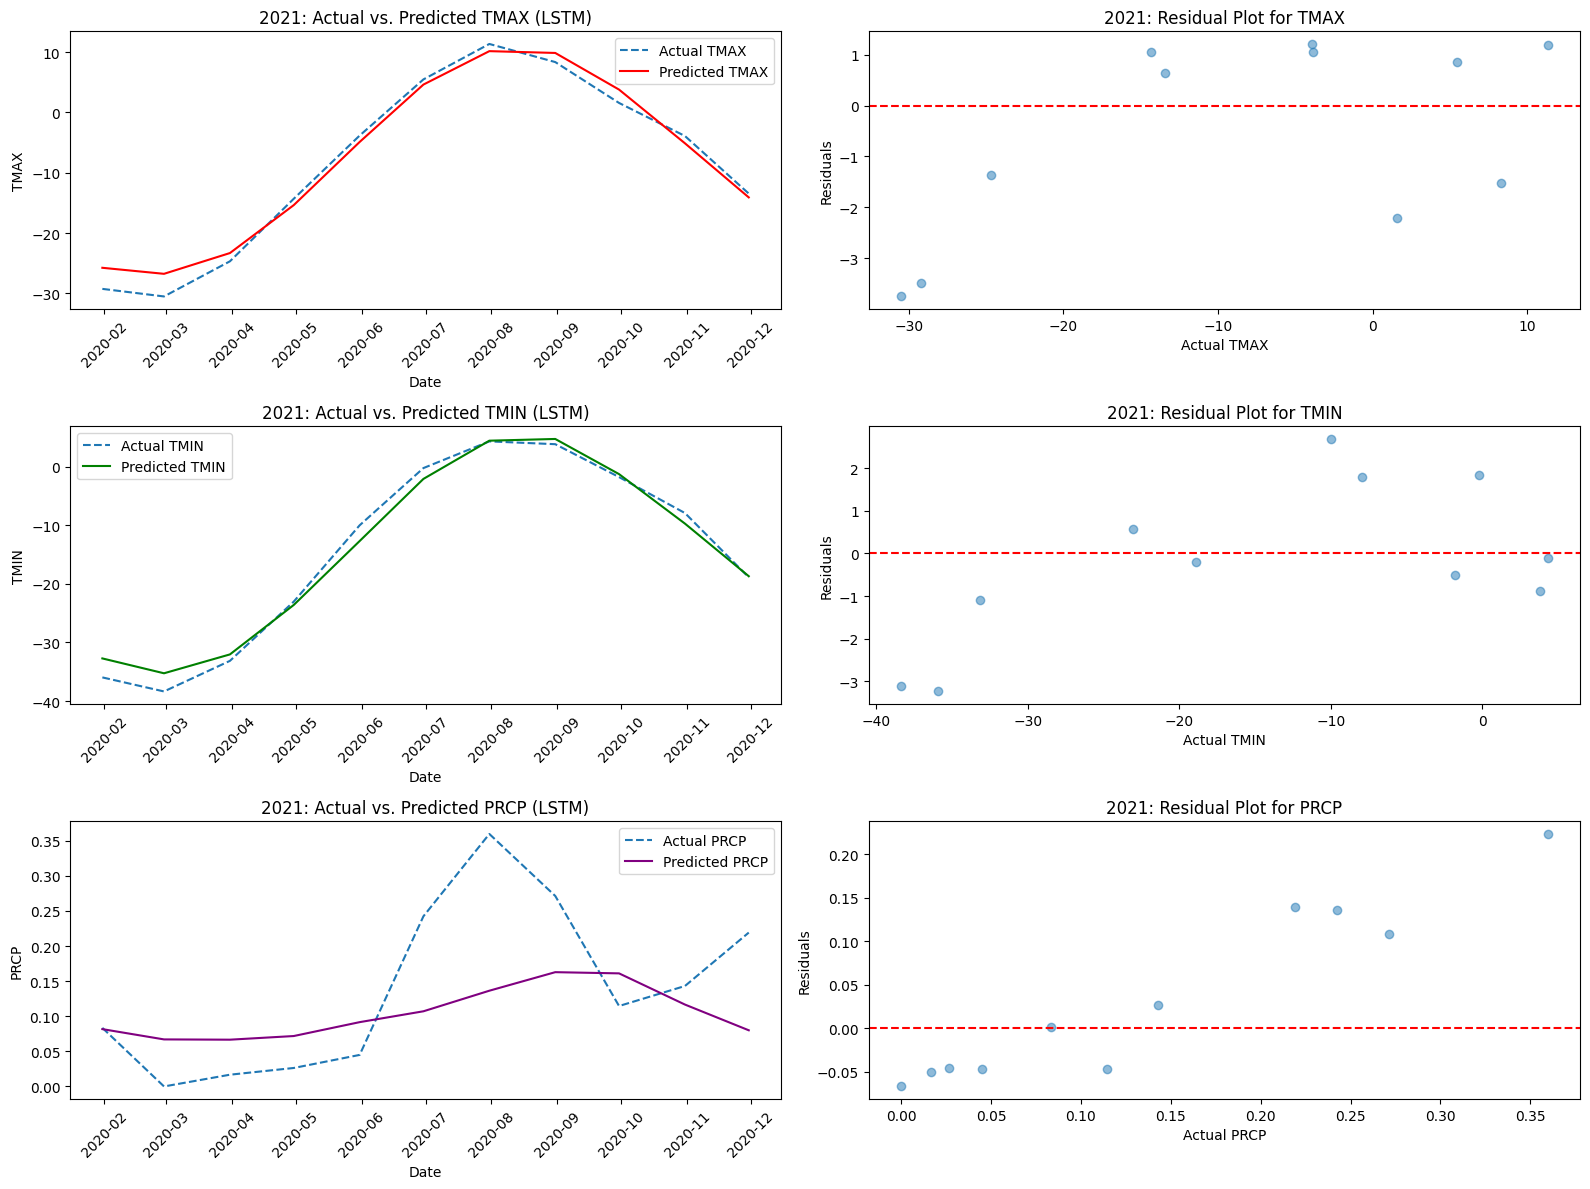

In [ ]:
# --- Plot Actual vs Predicted + Residuals ---
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
variables = ['TMAX', 'TMIN', 'PRCP']
colors = ['red', 'green', 'purple']

for i in range(3):
    # Actual vs Predicted
    axes[i, 0].plot(dates_test, y_test_inv[:, i], label=f"Actual {variables[i]}", linestyle='--')
    axes[i, 0].plot(dates_test, y_pred_inv[:, i], label=f"Predicted {variables[i]}", color=colors[i])
    axes[i, 0].set_title(f"2021: Actual vs. Predicted {variables[i]} (LSTM)")
    axes[i, 0].set_xlabel("Date")
    axes[i, 0].set_ylabel(variables[i])
    axes[i, 0].legend()
    axes[i, 0].tick_params(axis='x', rotation=45)

    # Residual plot
    residuals = y_test_inv[:, i] - y_pred_inv[:, i]
    axes[i, 1].scatter(y_test_inv[:, i], residuals, alpha=0.5)
    axes[i, 1].axhline(0, color='red', linestyle='dashed')
    axes[i, 1].set_title(f"2021: Residual Plot for {variables[i]}")
    axes[i, 1].set_xlabel(f"Actual {variables[i]}")
    axes[i, 1].set_ylabel("Residuals")

plt.tight_layout()
plt.show()

### Using XGBoost model

In [ ]:
# Convert daily data to weekly & monthly averages
df_weekly = df_weather.resample("W").mean()  # Weekly Averages
df_monthly = df_weather.resample("M").mean()  # Monthly Averages

# Reset index for modeling
df_weekly.reset_index(inplace=True)
df_monthly.reset_index(inplace=True)

# Add cyclical encoding for seasonality
df_monthly['Month'] = df_monthly['date'].dt.month
df_monthly['Year'] = df_monthly['date'].dt.year

# Convert month into cyclic feature (to represent seasonality)
df_monthly['Month_sin'] = np.sin(2 * np.pi * df_monthly['Month'] / 12)
df_monthly['Month_cos'] = np.cos(2 * np.pi * df_monthly['Month'] / 12)

# Lag features (previous years' climate as input)
df_monthly['TMAX_lag12'] = df_monthly['TMAX'].shift(12)
df_monthly['TMIN_lag12'] = df_monthly['TMIN'].shift(12)
df_monthly['PRCP_lag12'] = df_monthly['PRCP'].shift(12)
df_monthly['TMAX_lag24'] = df_monthly['TMAX'].shift(24)
df_monthly['TMIN_lag24'] = df_monthly['TMIN'].shift(24)
df_monthly['PRCP_lag24'] = df_monthly['PRCP'].shift(24)


<ipython-input-20-11d88948f9d7>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_weather.resample("M").mean()  # Monthly Averages


In [ ]:
# Drop NaN values (from lag features)
df_monthly.dropna(inplace=True)

# Define input features and target variable
features = ['TMAX', 'TMIN', 'PRCP', 'Month_sin', 'Month_cos',
            'TMAX_lag12', 'TMIN_lag12', 'PRCP_lag12',
            'TMAX_lag24', 'TMIN_lag24', 'PRCP_lag24']

target = ['TMAX', 'TMIN', 'PRCP']  # Predict next year's climate

# Train on data before 2020, test on 2020 climate data
train = df_monthly[df_monthly['Year'] < 2020]
test = df_monthly[df_monthly['Year'] == 2020]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Train XGBoost model for multi-output regression
model_climate = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_climate.fit(X_train, y_train)

# Predict the next year's climate
y_pred_climate = model_climate.predict(X_test)

# Convert predictions to DataFrame
y_pred_climate_df = pd.DataFrame(y_pred_climate, columns=target, index=y_test.index)

# Compute residuals
residuals = y_test - y_pred_climate_df

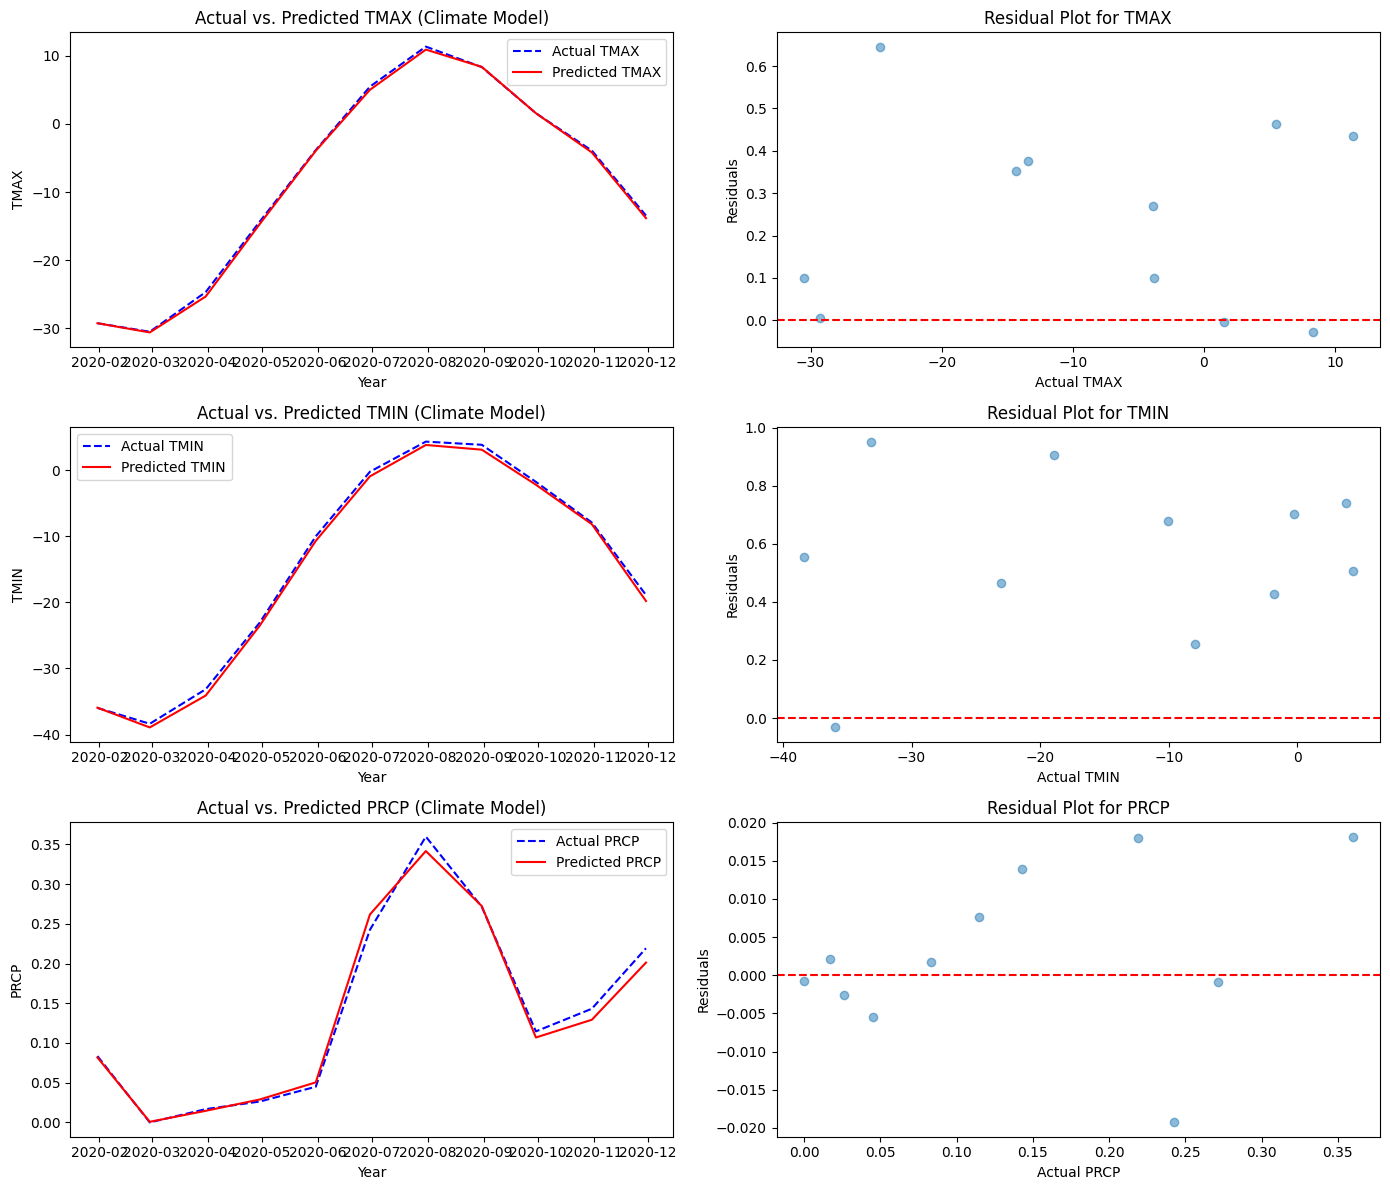

Climate Model MAE: 0.28
R² Score: 1.00


In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))

for i, col in enumerate(target):
    # Actual vs Predicted
    axes[i, 0].plot(test['date'], y_test[col], label=f"Actual {col}", color="blue", linestyle='dashed')
    axes[i, 0].plot(test['date'], y_pred_climate_df[col], label=f"Predicted {col}", color="red")
    axes[i, 0].set_xlabel("Year")
    axes[i, 0].set_ylabel(col)
    axes[i, 0].legend()
    axes[i, 0].set_title(f"Actual vs. Predicted {col} (Climate Model)")

    # Residuals
    axes[i, 1].scatter(y_test[col], residuals[col], alpha=0.5)
    axes[i, 1].axhline(0, color='red', linestyle='dashed')
    axes[i, 1].set_xlabel(f"Actual {col}")
    axes[i, 1].set_ylabel("Residuals")
    axes[i, 1].set_title(f"Residual Plot for {col}")

plt.tight_layout()
plt.show()

# Compute errors
mae_climate = mean_absolute_error(y_test, y_pred_climate_df)
r2_climate = r2_score(y_test, y_pred_climate_df)

print(f"Climate Model MAE: {mae_climate:.2f}")
print(f"R² Score: {r2_climate:.2f}")

Adding more lag features increased the MAE slightly. This might be due to increased complexity without meaningful new information. You can experiment by selectively removing the lag features (e.g., keeping only 12-month and 24-month lags) and checking if the MAE improves.

## Task 2: Predicting Weather (short-term)

### Using LTSM

In [ ]:
# ----- Filter and Scale -----
df_weather_daily = df_weather[["TMAX", "TMIN", "PRCP"]].copy()
df_weather_daily = df_weather_daily[df_weather_daily.index.year <= 2020]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_weather_daily)

In [ ]:
# ----- Create sequences -----
def create_sequences_with_dates(data, dates, seq_length=7):
    X, y, date_list = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
        date_list.append(dates[i+seq_length])
    return np.array(X), np.array(y), np.array(date_list)

seq_length = 7
X_all, y_all, dates_all = create_sequences_with_dates(scaled_data, df_weather_daily.index, seq_length)

In [ ]:
# ----- Split into train (pre-2020) and test (2020 only) -----
train_mask = pd.to_datetime(dates_all).year < 2020
test_mask = pd.to_datetime(dates_all).year == 2020

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_test, y_test = X_all[test_mask], y_all[test_mask]
dates_test = dates_all[test_mask]

In [ ]:
# ----- LSTM Model -----
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1])
])
model.compile(optimizer='adam', loss='mae')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=16, callbacks=[early_stop], verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


296/296 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.1175 - val_loss: 0.0644
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0501 - val_loss: 0.0530
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0447 - val_loss: 0.0506
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0425 - val_loss: 0.0527
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0424 - val_loss: 0.0496
Epoch 6/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0401 - val_loss: 0.0481
Epoch 7/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0383 - val_loss: 0.0469
Epoch 8/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0373 - val_loss: 0.0495
Epoch 9/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0374 - val_loss: 0.0462
Epoch 10/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0371 - val_loss: 0.0465
Epoch 11/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0385 - val_loss: 0.0461
Epoch 12/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0

In [ ]:
# ----- Predictions -----
y_pred = model.predict(X_test)

# ----- Inverse scale -----
y_test_inv = scaler.inverse_transform(np.hstack([y_test]))
y_pred_inv = scaler.inverse_transform(np.hstack([y_pred]))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


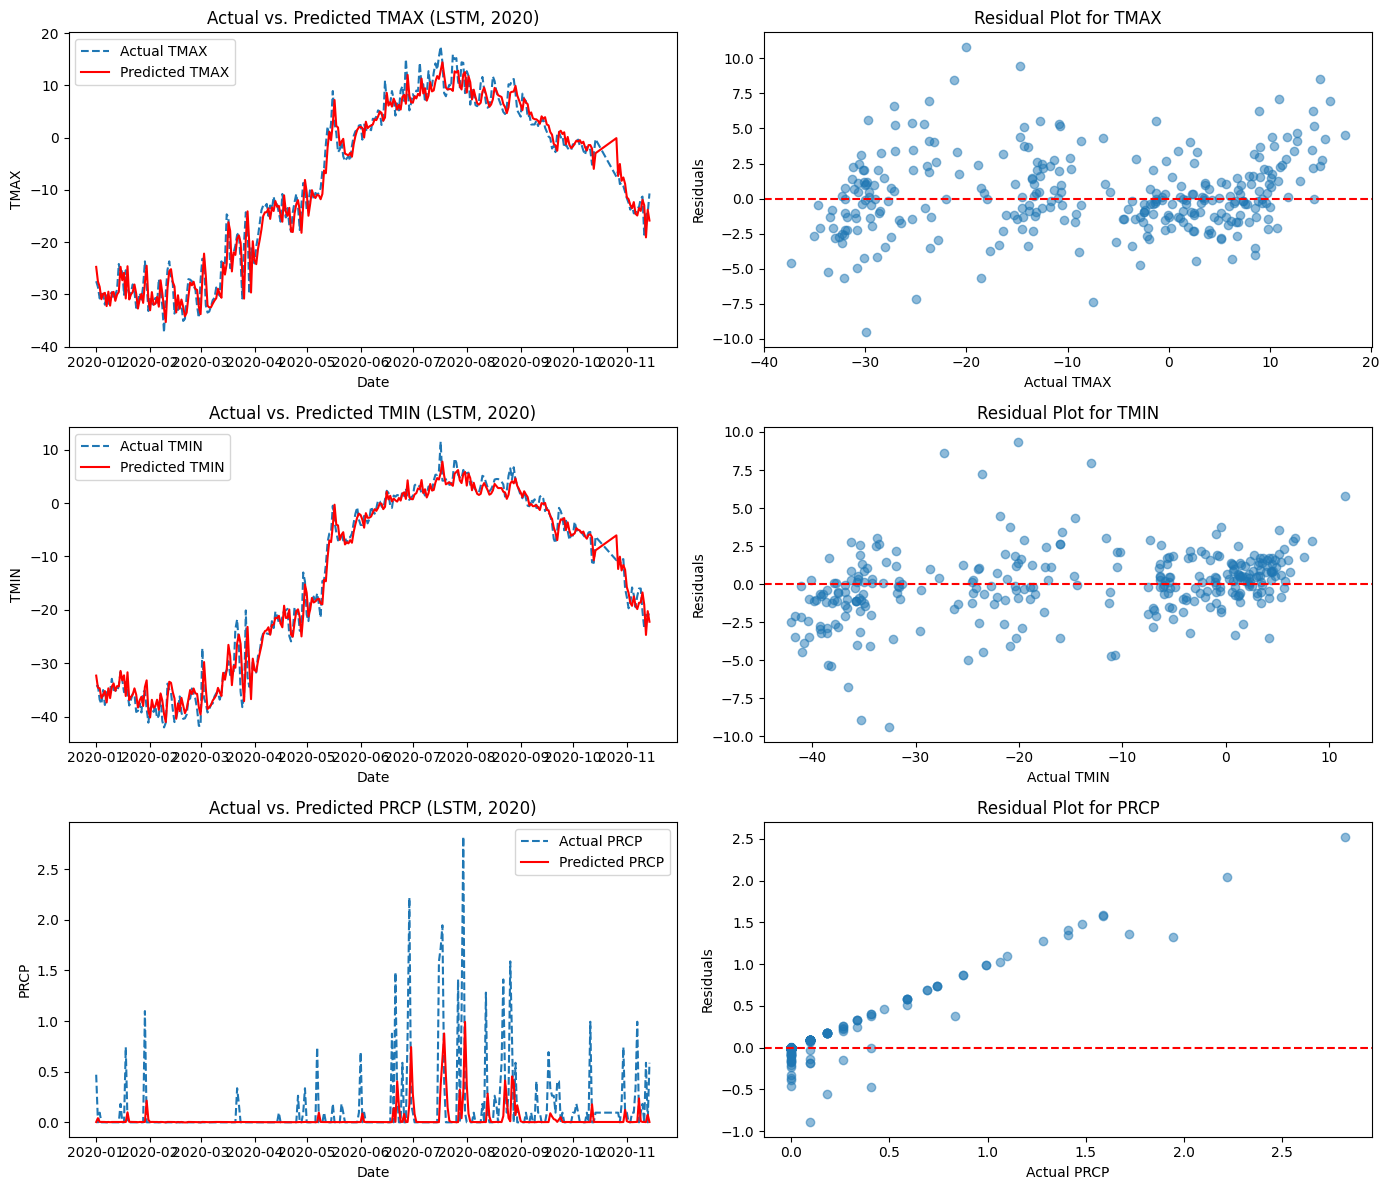

In [ ]:
# ----- Plot -----
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
labels = ['TMAX', 'TMIN', 'PRCP']

for i in range(3):
    # Actual vs Predicted
    axes[i, 0].plot(dates_test, y_test_inv[:, i], label=f"Actual {labels[i]}", linestyle='--')
    axes[i, 0].plot(dates_test, y_pred_inv[:, i], label=f"Predicted {labels[i]}", color='red')
    axes[i, 0].set_title(f"Actual vs. Predicted {labels[i]} (LSTM, 2020)")
    axes[i, 0].set_xlabel("Date")
    axes[i, 0].set_ylabel(labels[i])
    axes[i, 0].legend()

    # Residuals
    residuals = y_test_inv[:, i] - y_pred_inv[:, i]
    axes[i, 1].scatter(y_test_inv[:, i], residuals, alpha=0.5)
    axes[i, 1].axhline(0, color='red', linestyle='dashed')
    axes[i, 1].set_xlabel(f"Actual {labels[i]}")
    axes[i, 1].set_ylabel("Residuals")
    axes[i, 1].set_title(f"Residual Plot for {labels[i]}")

plt.tight_layout()
plt.show()

### Using XGBoost model

In [ ]:
# Convert daily data to weekly & monthly averages
df_weather.index = pd.to_datetime(df_weather.index)
df_daily = df_weather.copy()

# Add cyclical encoding for seasonality
df_daily['Month'] = df_daily.index.month
df_daily['DayOfWeek'] = df_daily.index.dayofweek
df_daily['Month_sin'] = np.sin(2 * np.pi * df_daily['Month'] / 12)
df_daily['Month_cos'] = np.cos(2 * np.pi * df_daily['Month'] / 12)

# Lag features (past weather conditions)
for lag in [1, 3, 7, 14, 30]:
    df_daily[f'TMAX_lag{lag}'] = df_daily['TMAX'].shift(lag)
    df_daily[f'TMIN_lag{lag}'] = df_daily['TMIN'].shift(lag)
    df_daily[f'PRCP_lag{lag}'] = df_daily['PRCP'].shift(lag)

# Rolling statistics for trends & variability
df_daily['TMAX_rolling_mean7'] = df_daily['TMAX'].rolling(window=7).mean()
df_daily['TMIN_rolling_mean7'] = df_daily['TMIN'].rolling(window=7).mean()
df_daily['PRCP_rolling_sum7'] = df_daily['PRCP'].rolling(window=7).sum()
df_daily['TMAX_rolling_std7'] = df_daily['TMAX'].rolling(window=7).std()
df_daily['TMIN_rolling_std7'] = df_daily['TMIN'].rolling(window=7).std()

# Day-to-day change (delta feature)
df_daily['TMAX_delta'] = df_daily['TMAX'].diff()
df_daily['TMIN_delta'] = df_daily['TMIN'].diff()
df_daily['PRCP_delta'] = df_daily['PRCP'].diff()

# Drop NaN values from rolling stats and lags
df_daily.dropna(inplace=True)



In [ ]:
# Define input features and target variable
features = [
    'TMAX', 'TMIN', 'PRCP', 'Month_sin', 'Month_cos', 'DayOfWeek'
] + [
    f'TMAX_lag{lag}' for lag in [1, 3, 7, 14, 30]
] + [
    f'TMIN_lag{lag}' for lag in [1, 3, 7, 14, 30]
] + [
    f'PRCP_lag{lag}' for lag in [1, 3, 7, 14, 30]
] + [
    'TMAX_rolling_mean7', 'TMIN_rolling_mean7', 'PRCP_rolling_sum7',
    'TMAX_rolling_std7', 'TMIN_rolling_std7',
    'TMAX_delta', 'TMIN_delta', 'PRCP_delta'
]


target = ['TMAX', 'TMIN', 'PRCP']  # Predict next day's weather

# Train-test split (train on data before 2020, test on 2020)
train = df_daily[df_daily.index.year < 2020]
test = df_daily[df_daily.index.year == 2020]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Train XGBoost model for multi-output regression
model_weather = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_weather.fit(X_train, y_train)

# Predict the next day's weather
y_pred_weather = model_weather.predict(X_test)

Weather Model MAE: 0.05
Naive Baseline MAE: 1.34


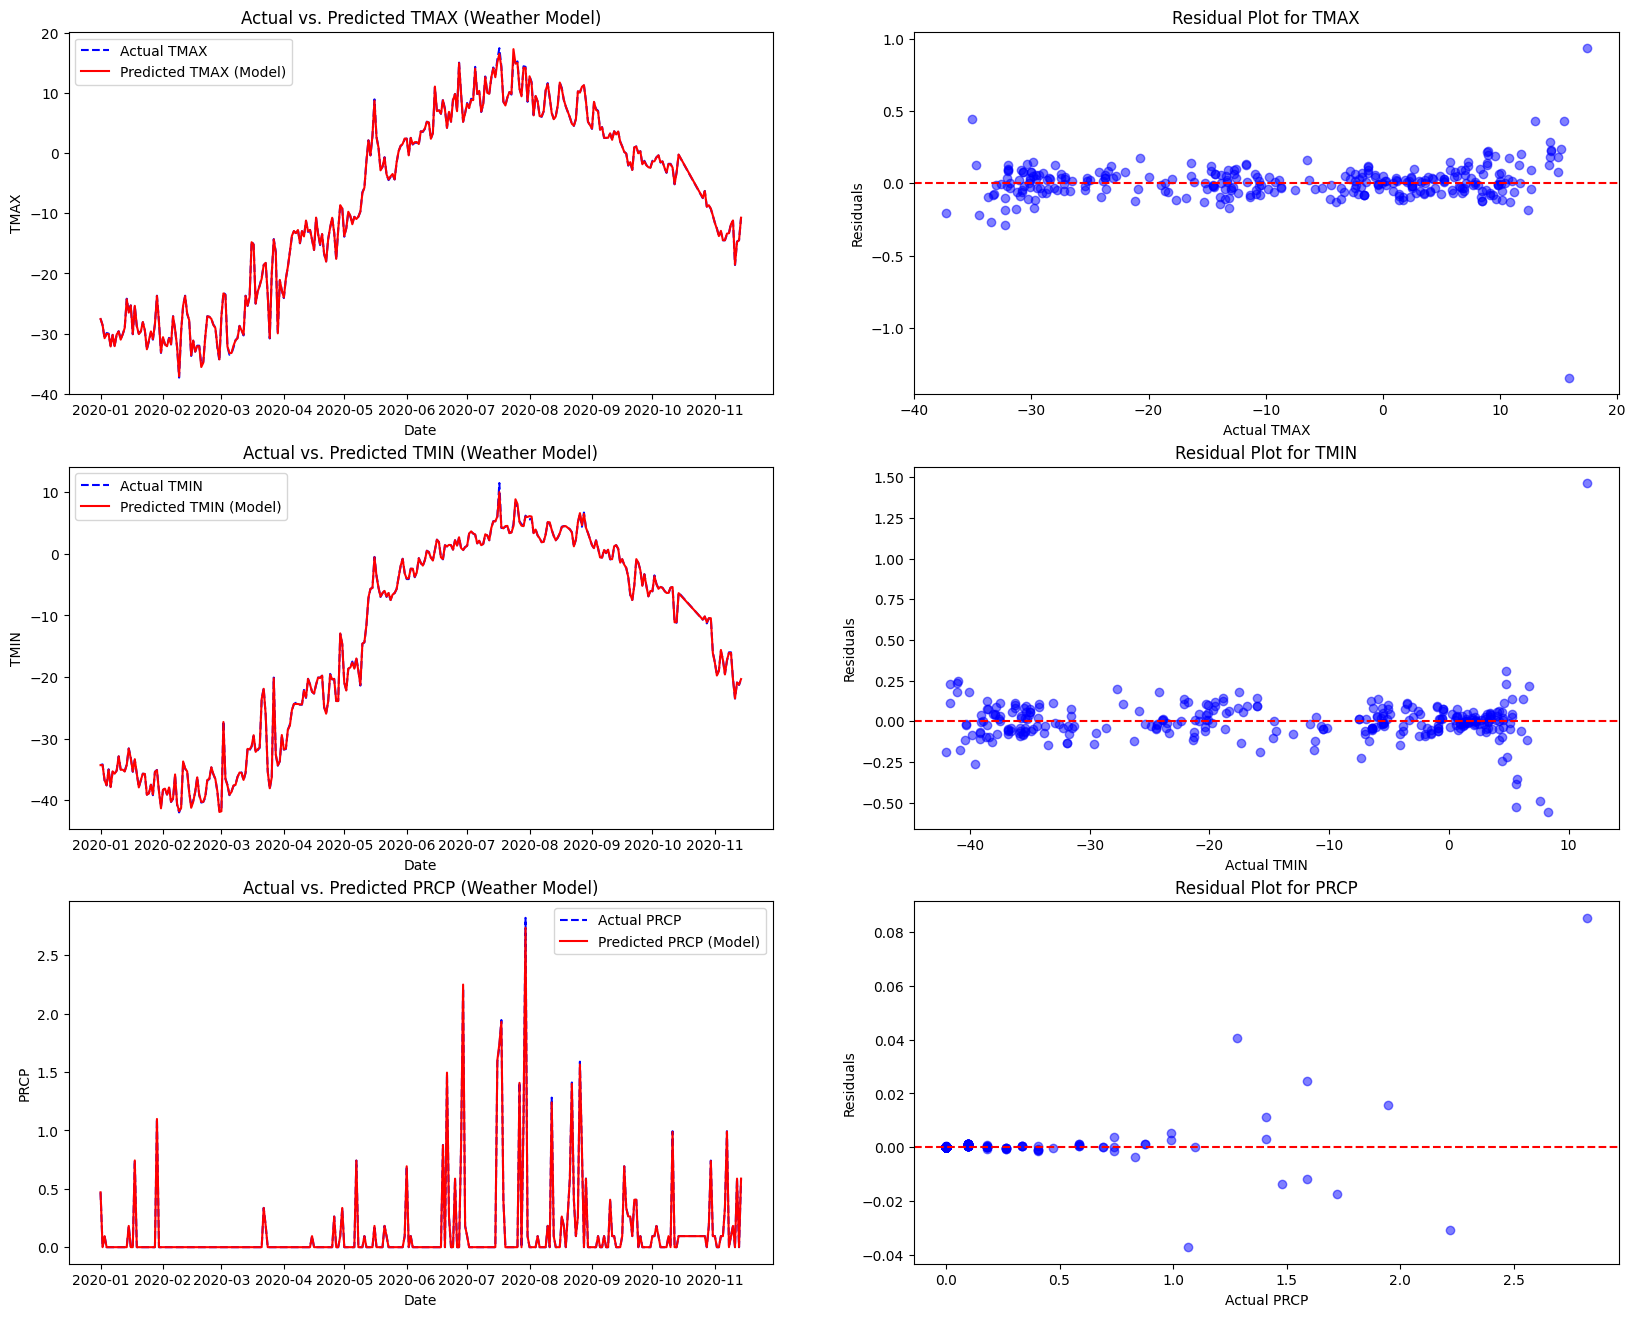

In [ ]:
# Compute errors
mae_weather = mean_absolute_error(y_test, y_pred_weather)
print(f"Weather Model MAE: {mae_weather:.2f}")

# Naive baseline (tomorrow = today)
naive_pred = test[target].shift(1).dropna()
naive_mae = mean_absolute_error(naive_pred, y_test.loc[naive_pred.index])
print(f"Naive Baseline MAE: {naive_mae:.2f}")

# Compute residuals
residuals = y_test - pd.DataFrame(y_pred_weather, columns=target, index=y_test.index) # Convert to DataFrame with correct index

# Plot actual vs predicted weather
plt.figure(figsize=(20, 16))

for i, col in enumerate(target):
    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(test.index, y_test[col], label=f"Actual {col}", color="blue", linestyle='dashed')
    plt.plot(test.index, y_pred_weather[:, i], label=f"Predicted {col} (Model)", color="red")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.title(f"Actual vs. Predicted {col} (Weather Model)")

    # Residual plot
    plt.subplot(3, 2, 2 * i + 2)
    plt.scatter(y_test[col], residuals[col], color='blue', alpha=0.5)  # Access residuals using column name
    plt.axhline(y=0, color='red', linestyle='dashed')
    plt.xlabel(f"Actual {col}")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {col}")

Discuss plots...

Model improves over naive baseline by 96.21%


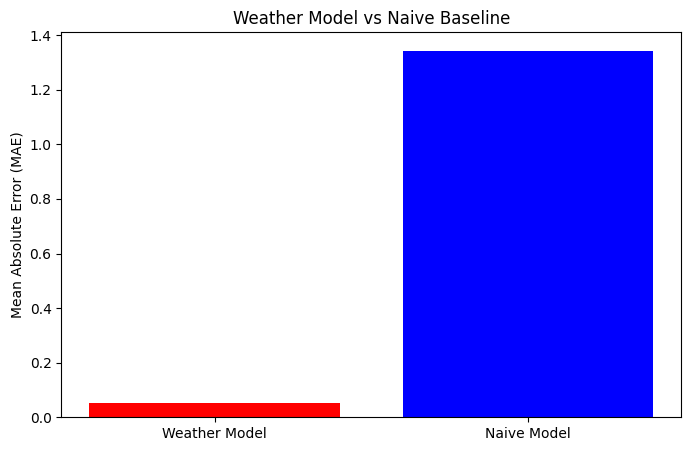

In [ ]:
# Compare performance
improvement = ((naive_mae - mae_weather) / naive_mae) * 100
print(f"Model improves over naive baseline by {improvement:.2f}%")

# Plot comparison
plt.figure(figsize=(8, 5))
plt.bar(['Weather Model', 'Naive Model'], [mae_weather, naive_mae], color=['red', 'blue'])
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Weather Model vs Naive Baseline')
plt.show()

Discuss how its better than a simple yesterday - tomorrow...

In [ ]:
# Check if actual weather data exists for the forecasted period
actual_data = df_daily.loc['2020-11-16':'2020-11-29', ['TMAX', 'TMIN', 'PRCP']]

# Display available data
print(actual_data)


Empty DataFrame
Columns: [TMAX, TMIN, PRCP]
Index: []


Discuss...

## Extensions

### 1. Can you train a machine learning technique to predict 10 or 20 years into the future?

---

In [ ]:
# --- Load your df_monthly with TMAX, TMIN, PRCP ---
# Add cyclical features
df_monthly['Month'] = df_monthly['date'].dt.month
df_monthly['Month_sin'] = np.sin(2 * np.pi * df_monthly['Month'] / 12)
df_monthly['Month_cos'] = np.cos(2 * np.pi * df_monthly['Month'] / 12)

# Feature and target setup
features = ['TMAX', 'TMIN', 'PRCP', 'Month_sin', 'Month_cos']
target = ['TMAX', 'TMIN', 'PRCP']

# Scale features
scaler = MinMaxScaler()
df_scaled = df_monthly.copy()
df_scaled[features] = scaler.fit_transform(df_scaled[features])


In [ ]:
# Create sequences
def create_sequences(data, sequence_length=12):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length][:3])
    return np.array(X), np.array(y)

data_array = df_scaled[features].values
X, y = create_sequences(data_array)

# --- Train LSTM model ---
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y.shape[1])
])
model.compile(optimizer='adam', loss='mae')
model.fit(X, y, epochs=100, batch_size=8, verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.3017
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1676
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1092
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0969
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0928
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0839
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0974
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0905
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0860
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0944
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0834
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0788
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0793
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0835
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0857
Epoch 16/100
31/

In [ ]:
# --- Forecasting 20 years ahead ---
forecast_input = data_array[-12:].copy()
forecast_months = 20 * 12
forecast_preds = []
forecast_dates = [df_monthly['date'].iloc[-1] + pd.DateOffset(months=i+1) for i in range(forecast_months)]

for i in range(forecast_months):
    input_seq = np.expand_dims(forecast_input[-12:], axis=0)
    pred = model.predict(input_seq, verbose=0)[0]
    forecast_preds.append(pred)

    # Generate cyclical month features
    date = forecast_dates[i]
    month_sin = np.sin(2 * np.pi * date.month / 12)
    month_cos = np.cos(2 * np.pi * date.month / 12)
    forecast_input = np.vstack([forecast_input, np.array([*pred, month_sin, month_cos])])

# Inverse transform predictions
padded = np.hstack([forecast_preds, np.zeros((forecast_months, len(features) - 3))])
forecast_inv = scaler.inverse_transform(padded)[:, :3]

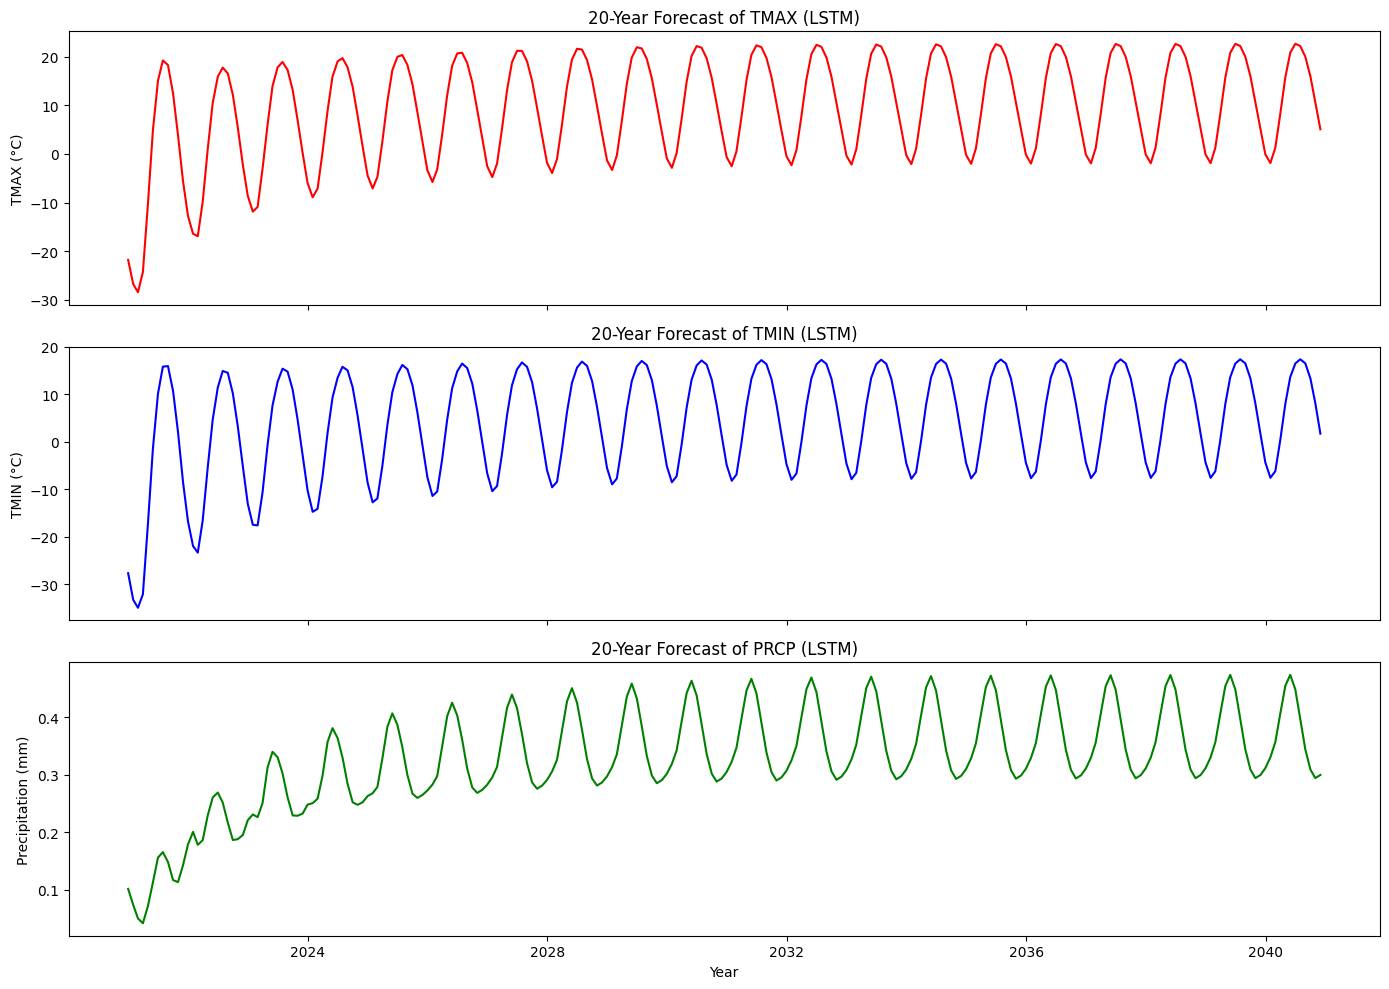

In [ ]:
# --- Plotting ---
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
labels = ['TMAX (°C)', 'TMIN (°C)', 'Precipitation (mm)']
colors = ['red', 'blue', 'green']

for i in range(3):
    axes[i].plot(forecast_dates, forecast_inv[:, i], color=colors[i])
    axes[i].set_title(f"20-Year Forecast of {target[i]} (LSTM)")
    axes[i].set_ylabel(labels[i])

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

### 2. Where will the hottest part of the world be in 20 years time?

In [ ]:
# ---------- Parse .dly file ----------
def parse_dly_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = {'DATE': [], 'TMAX': []}
    for line in lines:
        year = int(line[11:15])
        month = int(line[15:17])
        element = line[17:21]
        if element == 'TMAX':
            for day in range(31):
                value = int(line[21 + day * 8:26 + day * 8])
                if value != -9999:
                    try:
                        d = date(year, month, day + 1)
                        data['DATE'].append(d)
                        data['TMAX'].append(value * 0.1)
                    except ValueError:
                        continue
    # Convert 'DATE' column to datetime objects
    df = pd.DataFrame(data)
    df['DATE'] = pd.to_datetime(df['DATE'])  # This line was added
    return df

In [ ]:
# ---------- Train LSTM ----------
def train_forecast_lstm(df, forecast_months=240):
    df = df.set_index('DATE').resample('M').mean().dropna()
    values = df[['TMAX']].values
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)

    def create_sequences(data, seq_length=12):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    seq_length = 12
    X, y = create_sequences(scaled, seq_length)

    model = Sequential([
        LSTM(32, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=20, verbose=0)

    forecast = list(scaled[-seq_length:])
    predictions = []
    for _ in range(forecast_months):
        x_input = np.array(forecast[-seq_length:]).reshape(1, seq_length, 1)
        pred = model.predict(x_input, verbose=0)
        predictions.append(pred[0, 0])
        forecast.append(pred[0])

    forecast_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return forecast_values


In [ ]:

for root, dirs, files in os.walk("."):
    for file in files:
        if file.endswith(".dly"):
            print(os.path.join(root, file))


./CA002400404.dly


In [ ]:
data_dir = "Documents"  # or the actual folder name where your files are

stations = {
    "SHARJAH AIRPORT, UAE": "AE000041196.dly",
    "NORTH SALANG, Afghanistan": "AF000040930.dly",
    "ALGER-DAR EL BEIDA, Algeria": "AG000060390.dly",
    "LUANDA, Angola": "AO000066160.dly",
    "LEARMONTH AIRPORT, Australia": "ASN00005007.dly"
}

forecast_results = {}
for name, filename in stations.items():
    filepath = os.path.join(data_dir, filename)
    if os.path.exists(filepath):
        df = parse_dly_file(filepath)
        forecast = train_forecast_lstm(df)
        forecast_results[name] = forecast
    else:
        print(f"❌ File not found: {filepath}")
        forecast_results[name] = None


❌ File not found: Documents/AE000041196.dly
❌ File not found: Documents/AF000040930.dly
❌ File not found: Documents/AG000060390.dly
❌ File not found: Documents/AO000066160.dly
❌ File not found: Documents/ASN00005007.dly


In [ ]:
# ---------- Compare average future temperature ----------
avg_tmax_2044 = {
    name: np.mean(values)
    for name, values in forecast_results.items()
    if values is not None
}

hottest = max(avg_tmax_2044, key=avg_tmax_2044.get)

# ---------- Results ----------
print("\n🌍 Average Predicted TMAX (Next 20 Years):")
for location, avg_temp in avg_tmax_2044.items():
    print(f"{location}: {avg_temp:.2f} °C")

print(f"\n🔥 Hottest in 2044: {hottest} with average TMAX of {avg_tmax_2044[hottest]:.2f} °C")


ValueError: max() arg is an empty sequence

### 3. What else can you study with this dataset? Is the Sun in Utah a predictor of the rain in Spain?

### 4. How close do weather stations need to be to provide reliable forecasts at other stations?